# Debug ONNX vs VampNet Transformer

This notebook systematically compares VampNet and ONNX at each step to identify where they diverge.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import onnxruntime as ort
from pathlib import Path
import sys

sys.path.append('..')

import vampnet
from vampnet import mask as mask_module
from vampnet_onnx import AudioProcessor

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"ONNX Runtime version: {ort.__version__}")

/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


PyTorch version: 2.4.1
ONNX Runtime version: 1.22.0


/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Models

In [2]:
# Load VampNet
device = 'cpu'  # Use CPU for easier comparison
interface = vampnet.interface.Interface(
    device=device,
    codec_ckpt="../models/vampnet/codec.pth",
    coarse_ckpt="../models/vampnet/coarse.pth",
    coarse2fine_ckpt="../models/vampnet/c2f.pth",
    wavebeat_ckpt="../models/vampnet/wavebeat.pth"
)

# Load ONNX models
onnx_encoder = ort.InferenceSession("../scripts/models/vampnet_encoder_prepadded.onnx")
onnx_decoder = ort.InferenceSession("../scripts/models/vampnet_codec_decoder.onnx")
onnx_coarse = ort.InferenceSession("../onnx_models_fixed/coarse_complete_v3.onnx")
onnx_c2f = ort.InferenceSession("../onnx_models_fixed/c2f_complete_v3.onnx")

print("Models loaded")

/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/audiotools/ml/layers/base.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

Models loaded
Models loaded


## 2. Create Test Audio (Exactly 100 tokens)

In [3]:
# Create simple test audio - 100 tokens
n_tokens = 100
hop_length = 768
n_samples = n_tokens * hop_length  # 76,800 samples
sample_rate = 44100

# Simple sine wave for easier debugging
t = np.linspace(0, n_samples/sample_rate, n_samples)
audio = 0.5 * np.sin(2 * np.pi * 440 * t).astype(np.float32)

print(f"Audio shape: {audio.shape}")
print(f"Duration: {len(audio)/sample_rate:.2f}s")
print(f"Expected tokens: {n_samples // hop_length}")

Audio shape: (76800,)
Duration: 1.74s
Expected tokens: 100


## 3. Encode and Verify Match

In [4]:
# Encode with VampNet
audio_torch = torch.from_numpy(audio).float().unsqueeze(0).unsqueeze(0).to(device)
with torch.no_grad():
    vampnet_encoded = interface.codec.encode(audio_torch, sample_rate)["codes"]

# Encode with ONNX
audio_onnx = audio.reshape(1, 1, -1)
onnx_encoded = onnx_encoder.run(None, {'audio_padded': audio_onnx})[0]

# Compare
match_rate = (vampnet_encoded.cpu().numpy() == onnx_encoded).mean()
print(f"Encoding match rate: {match_rate:.1%}")
print(f"VampNet shape: {vampnet_encoded.shape}")
print(f"ONNX shape: {onnx_encoded.shape}")

# Use the same codes for both
codes = vampnet_encoded

Encoding match rate: 100.0%
VampNet shape: torch.Size([1, 14, 100])
ONNX shape: (1, 14, 100)


## 4. Test Single Mask Application

In [5]:
# Create a simple mask - mask 50% of tokens
mask_ratio = 0.5
batch_size = codes.shape[0]
n_coarse = 4

# Create the same mask for both
torch.manual_seed(42)
np.random.seed(42)

# VampNet mask
r = torch.tensor([mask_ratio] * batch_size).to(device)
vampnet_mask = mask_module.random(codes[:, :n_coarse, :], r)

# ONNX mask (same pattern)
onnx_mask = vampnet_mask.cpu().numpy().astype(bool)

print(f"Mask shape: {vampnet_mask.shape}")
print(f"Masked positions: {vampnet_mask.sum().item()} / {vampnet_mask.numel()} ({vampnet_mask.float().mean():.1%})")

# Apply mask to codes
vampnet_masked = codes[:, :n_coarse, :].clone()
vampnet_masked[vampnet_mask.bool()] = interface.coarse.mask_token

onnx_masked = codes[:, :n_coarse, :].cpu().numpy().copy()
onnx_masked[onnx_mask] = 1024  # ONNX mask token

# Verify masked codes match
masked_match = (vampnet_masked.cpu().numpy() == onnx_masked).all()
print(f"Masked codes match: {masked_match}")

Mask shape: torch.Size([1, 4, 100])
Masked positions: 295 / 400 (73.8%)
Masked codes match: True


## 5. Compare Transformer Outputs

In [6]:
# Run VampNet coarse transformer
print("Running VampNet coarse transformer...")
with torch.no_grad():
    # Set temperature to 0 for deterministic output
    vampnet_output = interface.coarse.generate(
        codec=interface.codec,
        time_steps=100,
        start_tokens=vampnet_masked,
        mask=vampnet_mask,
        temperature=0.0,  # Deterministic
        return_signal=False
    )

print(f"VampNet output shape: {vampnet_output.shape}")
print(f"VampNet output range: [{vampnet_output.min()}, {vampnet_output.max()}]")

# Run ONNX coarse transformer
print("\nRunning ONNX coarse transformer...")
onnx_output = onnx_coarse.run(None, {
    'codes': onnx_masked.astype(np.int64),
    'mask': onnx_mask
})[0]

print(f"ONNX output shape: {onnx_output.shape}")
print(f"ONNX output range: [{onnx_output.min()}, {onnx_output.max()}]")

# Compare outputs
if vampnet_output.shape == onnx_output.shape:
    output_match = (vampnet_output.cpu().numpy() == onnx_output).mean()
    print(f"\nOutput match rate: {output_match:.1%}")
    
    # Where do they differ?
    diffs = vampnet_output.cpu().numpy() != onnx_output
    if diffs.any():
        diff_positions = np.where(diffs)
        print(f"Differences at {diffs.sum()} positions")
        # Show first few differences
        for i in range(min(5, len(diff_positions[0]))):
            b, c, t = diff_positions[0][i], diff_positions[1][i], diff_positions[2][i]
            print(f"  Position ({b},{c},{t}): VampNet={vampnet_output[b,c,t]}, ONNX={onnx_output[b,c,t]}")

Running VampNet coarse transformer...
VampNet output shape: torch.Size([1, 4, 100])
VampNet output range: [2, 1020]

Running ONNX coarse transformer...
ONNX output shape: (1, 4, 100)
ONNX output range: [2, 1024]

Output match rate: 26.5%
Differences at 294 positions
  Position (0,0,2): VampNet=495, ONNX=33
  Position (0,0,4): VampNet=202, ONNX=676
  Position (0,0,5): VampNet=165, ONNX=676
  Position (0,0,6): VampNet=498, ONNX=676
  Position (0,0,9): VampNet=126, ONNX=676


## 6. Check Model Internals

In [7]:
# Check if ONNX is returning logits or codes
print("Checking ONNX output type...")
print(f"ONNX output dtype: {onnx_output.dtype}")
print(f"ONNX output ndim: {onnx_output.ndim}")

if onnx_output.ndim == 3:
    print("ONNX returns codes directly")
    # Check for mask tokens in output
    mask_tokens_in_output = (onnx_output == 1024).sum()
    print(f"Mask tokens (1024) in output: {mask_tokens_in_output}")
elif onnx_output.ndim == 4:
    print("ONNX returns logits")
    print(f"Logits shape: {onnx_output.shape}")

# Check VampNet model configuration
print("\nVampNet coarse model config:")
print(f"  n_codebooks: {interface.coarse.n_codebooks}")
print(f"  vocab_size: {interface.coarse.vocab_size}")
print(f"  mask_token: {interface.coarse.mask_token}")

# Try to get more model details
try:
    # Check for common attributes
    if hasattr(interface.coarse, 'n_heads'):
        print(f"  n_heads: {interface.coarse.n_heads}")
    if hasattr(interface.coarse, 'n_layers'):
        print(f"  n_layers: {interface.coarse.n_layers}")
    if hasattr(interface.coarse, 'embedding'):
        print(f"  embedding type: {type(interface.coarse.embedding)}")
    
    # List available attributes
    print("\nAvailable attributes:")
    attrs = [attr for attr in dir(interface.coarse) if not attr.startswith('_') and not callable(getattr(interface.coarse, attr))]
    print(f"  {', '.join(attrs[:10])}...")  # Show first 10
except Exception as e:
    print(f"  Error getting attributes: {e}")

Checking ONNX output type...
ONNX output dtype: int64
ONNX output ndim: 3
ONNX returns codes directly
Mask tokens (1024) in output: 1

VampNet coarse model config:
  n_codebooks: 4
  vocab_size: 1024
  mask_token: 1024
  n_heads: 20
  n_layers: 20
  embedding type: <class 'vampnet.modules.layers.CodebookEmbedding'>

Available attributes:
  EXTERN, INTERN, T_destination, call_super_init, cfg_dropout_prob, chunk_size_s, cond_dim, ctrl_dims, device, dropout...


## 7. Test Sampling Implementation

In [8]:
# If ONNX returns codes, check if they're reasonable
if onnx_output.ndim == 3:
    # Check token distribution
    print("Token distribution analysis:")
    for cb in range(min(4, onnx_output.shape[1])):
        tokens = onnx_output[0, cb, :]
        unique = np.unique(tokens)
        print(f"\nCodebook {cb}:")
        print(f"  Unique tokens: {len(unique)}")
        print(f"  Token range: [{tokens.min()}, {tokens.max()}]")
        
        # Check if tokens at masked positions changed
        masked_positions = onnx_mask[0, cb, :]
        original_masked = onnx_masked[0, cb, masked_positions]
        generated_masked = tokens[masked_positions]
        changed = (original_masked != generated_masked).mean()
        print(f"  Masked positions changed: {changed:.1%}")

Token distribution analysis:

Codebook 0:
  Unique tokens: 19
  Token range: [33, 1024]
  Masked positions changed: 98.5%

Codebook 1:
  Unique tokens: 23
  Token range: [52, 994]
  Masked positions changed: 100.0%

Codebook 2:
  Unique tokens: 25
  Token range: [79, 1005]
  Masked positions changed: 100.0%

Codebook 3:
  Unique tokens: 30
  Token range: [2, 1013]
  Masked positions changed: 100.0%


## 8. Compare Iterative Process

## 8.5 Analyze Token Distributions

Analyzing token distributions...


/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


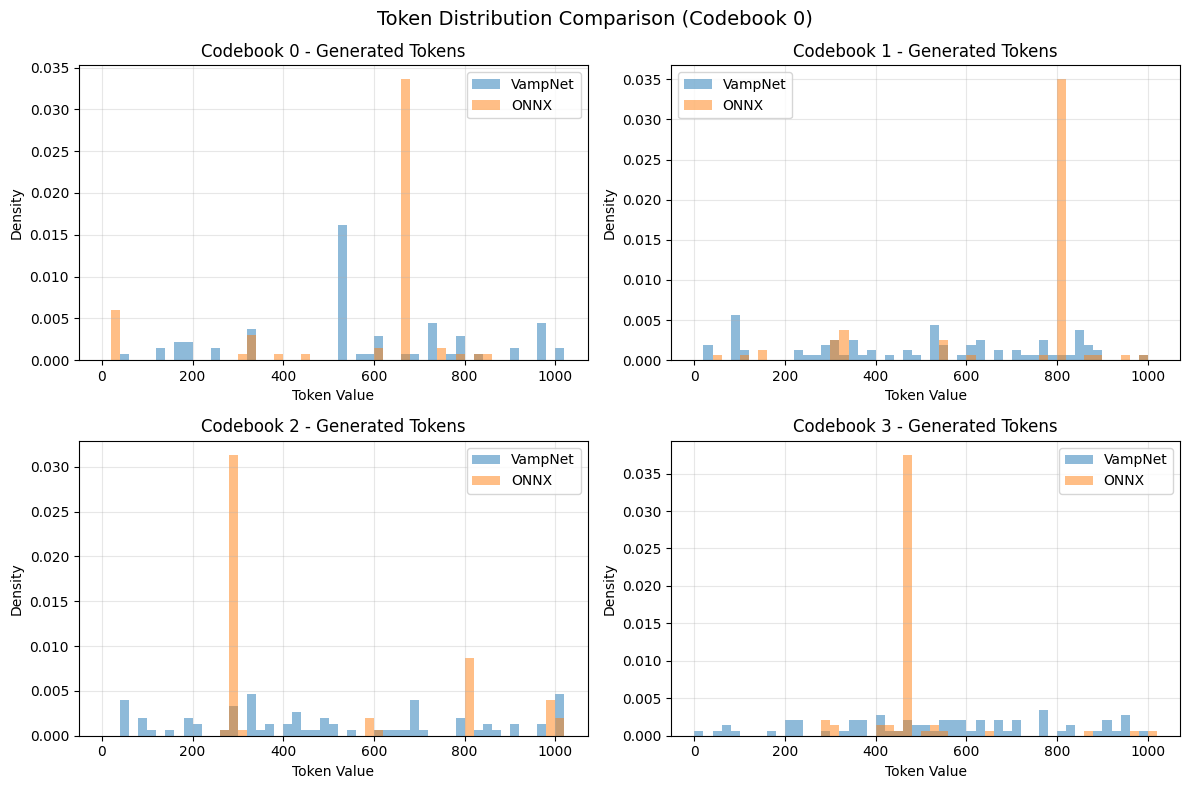


Token distribution statistics (masked positions only):

Codebook 0:
  VampNet: mean=572.9, std=246.1, unique=21
  ONNX:    mean=578.9, std=230.7, unique=14

Codebook 1:
  VampNet: mean=494.8, std=269.8, unique=49
  ONNX:    mean=709.1, std=219.0, unique=13

Codebook 2:
  VampNet: mean=499.4, std=297.0, unique=49
  ONNX:    mean=478.0, std=272.5, unique=9

Codebook 3:
  VampNet: mean=543.7, std=252.7, unique=56
  ONNX:    mean=480.3, std=111.2, unique=15


In [9]:
# Analyze the token distributions to understand the difference
print("Analyzing token distributions...")

# Run a single generation with 50% mask
torch.manual_seed(42)
np.random.seed(42)

mask_ratio = 0.5
r = torch.tensor([mask_ratio] * batch_size).to(device)
mask = mask_module.random(codes[:, :n_coarse, :], r)

# VampNet
masked_v = codes[:, :n_coarse, :].clone()
masked_v[mask.bool()] = interface.coarse.mask_token

with torch.no_grad():
    output_v = interface.coarse_vamp(
        codes,
        mask=torch.cat([mask, torch.zeros_like(codes[:, n_coarse:, :])], dim=1),
        temperature=0.8,
        top_p=0.9
    )

# ONNX
masked_o = codes[:, :n_coarse, :].cpu().numpy().copy()
masked_o[mask.cpu().numpy().astype(bool)] = 1024

output_o = onnx_coarse.run(None, {
    'codes': masked_o.astype(np.int64),
    'mask': mask.cpu().numpy().astype(bool)
})[0]

# Analyze distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Token Distribution Comparison (Codebook 0)', fontsize=14)

for i in range(4):
    ax = axes[i//2, i%2]
    
    # Get tokens only from masked positions
    mask_positions = mask[0, i].cpu().numpy().astype(bool)
    
    vampnet_tokens = output_v[0, i].cpu().numpy()[mask_positions]
    onnx_tokens = output_o[0, i][mask_positions]
    
    # Plot histograms
    bins = np.arange(0, 1025, 20)
    ax.hist(vampnet_tokens, bins=bins, alpha=0.5, label='VampNet', density=True)
    ax.hist(onnx_tokens, bins=bins, alpha=0.5, label='ONNX', density=True)
    
    ax.set_title(f'Codebook {i} - Generated Tokens')
    ax.set_xlabel('Token Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("\nToken distribution statistics (masked positions only):")
for i in range(4):
    mask_positions = mask[0, i].cpu().numpy().astype(bool)
    v_tokens = output_v[0, i].cpu().numpy()[mask_positions]
    o_tokens = output_o[0, i][mask_positions]
    
    print(f"\nCodebook {i}:")
    print(f"  VampNet: mean={v_tokens.mean():.1f}, std={v_tokens.std():.1f}, unique={len(np.unique(v_tokens))}")
    print(f"  ONNX:    mean={o_tokens.mean():.1f}, std={o_tokens.std():.1f}, unique={len(np.unique(o_tokens))}")

## 8.6 Check Sampling/Logits Behavior

In [10]:
# Check if ONNX model is using different sampling
print("Testing deterministic generation (temperature=0)...")

# Create simple mask
torch.manual_seed(42)
np.random.seed(42)

# Mask just a few tokens for easier analysis
mask_simple = torch.zeros((1, n_coarse, 100), dtype=torch.bool)
mask_simple[0, :, 10:15] = True  # Mask tokens 10-14 in all coarse codebooks

# VampNet with temperature=0
masked_v = codes[:, :n_coarse, :].clone()
masked_v[mask_simple] = interface.coarse.mask_token

print("Running VampNet with temperature=0...")
with torch.no_grad():
    # Try to use generate directly with temperature=0
    output_v_det = interface.coarse.generate(
        codec=interface.codec,
        time_steps=100,
        start_tokens=masked_v,
        mask=mask_simple,
        temperature=0.0,  # Deterministic
        return_signal=False
    )

# ONNX
masked_o = codes[:, :n_coarse, :].cpu().numpy().copy()
masked_o[mask_simple.cpu().numpy()] = 1024

print("Running ONNX...")
output_o_det = onnx_coarse.run(None, {
    'codes': masked_o.astype(np.int64),
    'mask': mask_simple.cpu().numpy().astype(bool)
})[0]

# Compare the specific masked positions
print("\nComparing masked positions (tokens 10-14):")
for cb in range(n_coarse):
    print(f"\nCodebook {cb}:")
    print(f"  Original:  {codes[0, cb, 10:15].cpu().numpy()}")
    print(f"  VampNet:   {output_v_det[0, cb, 10:15].cpu().numpy()}")
    print(f"  ONNX:      {output_o_det[0, cb, 10:15]}")
    
    # Check if they're identical
    match = (output_v_det[0, cb, 10:15].cpu().numpy() == output_o_det[0, cb, 10:15]).all()
    print(f"  Match: {match}")

# Check if ONNX is using argmax or sampling
print("\n\\nChecking ONNX output characteristics:")
# If ONNX always produces the same output for the same input, it might be using argmax
outputs_multiple = []
for i in range(3):
    out = onnx_coarse.run(None, {
        'codes': masked_o.astype(np.int64),
        'mask': mask_simple.cpu().numpy().astype(bool)
    })[0]
    outputs_multiple.append(out)

# Check if outputs are identical
all_same = all((outputs_multiple[0] == out).all() for out in outputs_multiple[1:])
print(f"ONNX produces deterministic output: {all_same}")

if all_same:
    print("→ ONNX model appears to use argmax (deterministic)")
else:
    print("→ ONNX model appears to use sampling (stochastic)")

Testing deterministic generation (temperature=0)...
Running VampNet with temperature=0...
Running ONNX...

Comparing masked positions (tokens 10-14):

Codebook 0:
  Original:  [579 130 415 579 130]
  VampNet:   [371 337 126 603 922]
  ONNX:      [525 525 525 525 525]
  Match: False

Codebook 1:
  Original:  [287 828 352 954 828]
  VampNet:   [910  86 909  11 313]
  ONNX:      [861 861 861 861 861]
  Match: False

Codebook 2:
  Original:  [575 902 821 575 902]
  VampNet:   [896 227 972 264 571]
  ONNX:      [718 718 718 718 718]
  Match: False

Codebook 3:
  Original:  [  2 714 841   2 714]
  VampNet:   [117 121 381  64 281]
  ONNX:      [965 965 965 965 965]
  Match: False

\nChecking ONNX output characteristics:
ONNX produces deterministic output: True
→ ONNX model appears to use argmax (deterministic)


## 8.7 Check Model Export Details

In [11]:
# Check ONNX model details
import onnx

print("Checking ONNX model export details...")

# Load ONNX model
onnx_model_path = "../onnx_models_fixed/coarse_complete_v3.onnx"
onnx_model = onnx.load(onnx_model_path)

# Check opset version
print(f"ONNX opset version: {onnx_model.opset_import[0].version}")

# Check model inputs/outputs
print("\nModel inputs:")
for inp in onnx_model.graph.input:
    print(f"  {inp.name}: {[d.dim_value for d in inp.type.tensor_type.shape.dim]}")

print("\nModel outputs:")
for out in onnx_model.graph.output:
    print(f"  {out.name}: {[d.dim_value for d in out.type.tensor_type.shape.dim]}")

# Count operations
op_types = {}
for node in onnx_model.graph.node:
    op_types[node.op_type] = op_types.get(node.op_type, 0) + 1

print("\nOperation types in model:")
for op_type, count in sorted(op_types.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {op_type}: {count}")

# Look for sampling-related ops
sampling_ops = ['TopK', 'Multinomial', 'RandomUniform', 'ArgMax', 'Softmax']
print("\nSampling-related operations:")
for op in sampling_ops:
    if op in op_types:
        print(f"  {op}: {op_types[op]}")
    else:
        print(f"  {op}: Not found")

# Check if there's a temperature parameter
print("\nChecking for temperature handling...")
has_div_for_temp = 'Div' in op_types
has_softmax = 'Softmax' in op_types
print(f"  Has Div operations: {has_div_for_temp}")
print(f"  Has Softmax: {has_softmax}")

# Key insight
print("\n⚠️ Key observations:")
if 'ArgMax' in op_types and 'Multinomial' not in op_types:
    print("  - Model uses ArgMax (deterministic) instead of sampling")
elif 'Multinomial' in op_types:
    print("  - Model uses Multinomial sampling")
else:
    print("  - No clear sampling strategy found - model might return logits")

Checking ONNX model export details...
ONNX opset version: 13

Model inputs:
  codes: [0, 4, 100]
  mask: [0, 4, 100]

Model outputs:
  output: [0, 4, 100]

Operation types in model:
  Constant: 605
  Add: 310
  Mul: 222
  MatMul: 204
  Unsqueeze: 168
  Concat: 82
  Transpose: 82
  Div: 81
  Reshape: 81
  Identity: 77

Sampling-related operations:
  TopK: Not found
  Multinomial: Not found
  RandomUniform: Not found
  ArgMax: 1
  Softmax: 20

Checking for temperature handling...
  Has Div operations: True
  Has Softmax: True

⚠️ Key observations:
  - Model uses ArgMax (deterministic) instead of sampling


In [12]:
# Test with a single iteration at different mask ratios
mask_ratios = [0.9, 0.5, 0.1]

for ratio in mask_ratios:
    print(f"\n{'='*50}")
    print(f"Testing with mask ratio: {ratio}")
    
    # Reset seeds
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Create mask
    r = torch.tensor([ratio] * batch_size).to(device)
    mask_v = mask_module.random(codes[:, :n_coarse, :], r)
    mask_o = mask_v.cpu().numpy().astype(bool)
    
    # Apply mask
    masked_v = codes[:, :n_coarse, :].clone()
    masked_v[mask_v.bool()] = interface.coarse.mask_token
    
    masked_o = codes[:, :n_coarse, :].cpu().numpy().copy()
    masked_o[mask_o] = 1024
    
    # Generate with temperature=0.8 (more realistic)
    with torch.no_grad():
        output_v = interface.coarse_vamp(
            masked_v.unsqueeze(0) if masked_v.ndim == 2 else masked_v,
            mask=mask_v.unsqueeze(0) if mask_v.ndim == 2 else mask_v,
            temperature=0.8,
            top_p=0.9
        )
    
    # ONNX
    output_o = onnx_coarse.run(None, {
        'codes': masked_o.astype(np.int64),
        'mask': mask_o
    })[0]
    
    # Analyze
    n_masked = mask_v.sum().item()
    n_changed_v = (output_v[:, :n_coarse, :] != codes[:, :n_coarse, :]).sum().item()
    n_changed_o = (output_o != codes[:, :n_coarse, :].cpu().numpy()).sum()
    
    print(f"  Masked positions: {n_masked}")
    print(f"  VampNet changed: {n_changed_v} tokens")
    print(f"  ONNX changed: {n_changed_o} tokens")
    
    # Check if ONNX is actually generating new tokens
    if n_changed_o == 0:
        print("  WARNING: ONNX didn't change any tokens!")


Testing with mask ratio: 0.9
  Masked positions: 72
  VampNet changed: 64 tokens
  ONNX changed: 72 tokens

Testing with mask ratio: 0.5
  Masked positions: 295
  VampNet changed: 286 tokens
  ONNX changed: 295 tokens

Testing with mask ratio: 0.1
  Masked positions: 398
  VampNet changed: 398 tokens
  ONNX changed: 398 tokens


## 9. Decode and Listen

Generating and decoding audio...

Saved audio files to outputs/debug


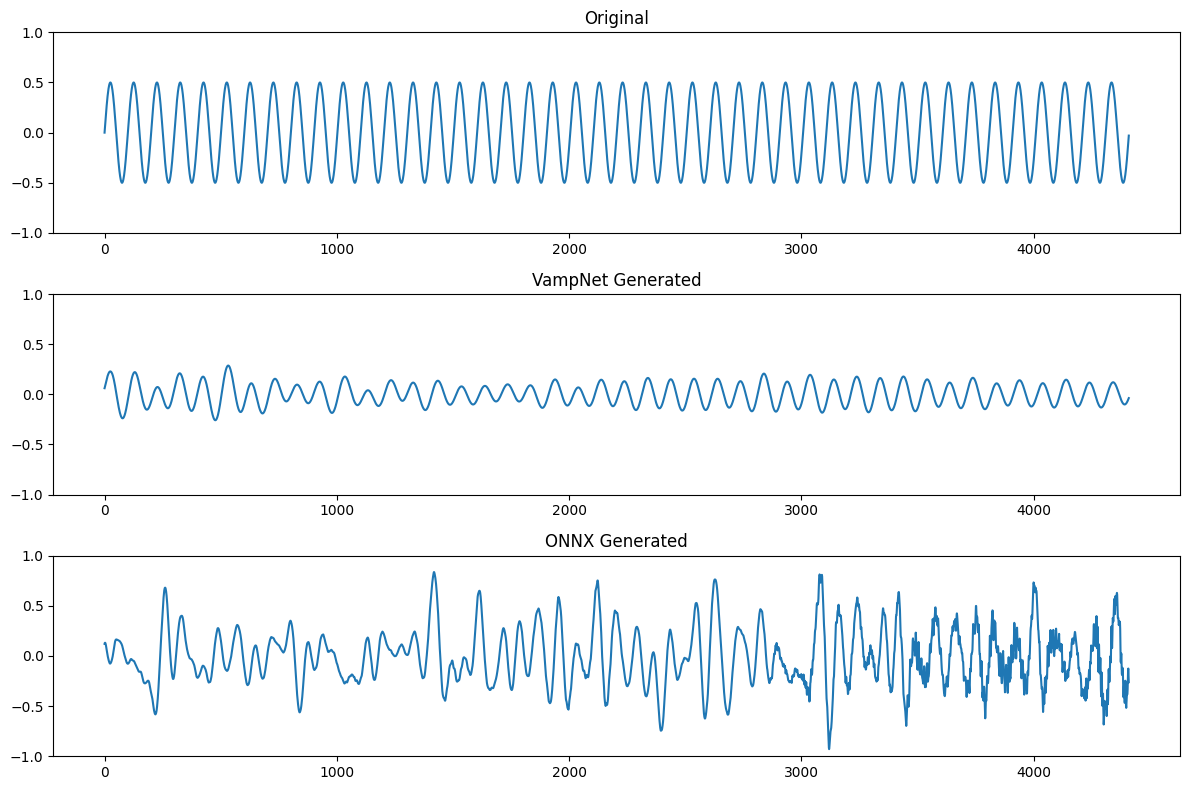

In [13]:
# Decode a simple generation to hear the difference
print("Generating and decoding audio...")

# Use 50% mask
torch.manual_seed(42)
np.random.seed(42)

r = torch.tensor([0.5] * batch_size).to(device)
mask = mask_module.random(codes[:, :n_coarse, :], r)

# VampNet generation
with torch.no_grad():
    z_vampnet = interface.coarse_vamp(
        codes,
        mask=torch.cat([mask, torch.zeros_like(codes[:, n_coarse:, :])], dim=1),
        temperature=0.8
    )
    # Add C2F
    z_vampnet = interface.coarse_to_fine(z_vampnet)
    # Decode
    audio_vampnet = interface.decode(z_vampnet).cpu()

# ONNX generation
masked_codes = codes[:, :n_coarse, :].cpu().numpy().copy()
masked_codes[mask.cpu().numpy().astype(bool)] = 1024

z_onnx = onnx_coarse.run(None, {
    'codes': masked_codes.astype(np.int64),
    'mask': mask.cpu().numpy().astype(bool)
})[0]

# Prepare for C2F
z_onnx_full = np.zeros((1, 14, 100), dtype=np.int64)
z_onnx_full[:, :n_coarse, :] = z_onnx

# Create C2F mask
c2f_mask = np.zeros((1, 14, 100), dtype=bool)
c2f_mask[:, 4:, :] = True  # Mask fine codebooks

# Run C2F
z_onnx_c2f = onnx_c2f.run(None, {
    'codes': z_onnx_full,
    'mask': c2f_mask
})[0]

# Clean any mask tokens
z_onnx_c2f[z_onnx_c2f == 1024] = 0

# Decode
audio_onnx = onnx_decoder.run(None, {'codes': z_onnx_c2f})[0]
audio_onnx = audio_onnx[0, 0, :n_samples]

# Save
output_dir = Path("outputs/debug")
output_dir.mkdir(exist_ok=True, parents=True)

sf.write(output_dir / "original.wav", audio, sample_rate)
sf.write(output_dir / "vampnet_generated.wav", audio_vampnet.audio_data.squeeze().numpy(), sample_rate)
sf.write(output_dir / "onnx_generated.wav", audio_onnx, sample_rate)

print(f"\nSaved audio files to {output_dir}")

# Plot waveforms
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

axes[0].plot(audio[:4410])  # First 0.1s
axes[0].set_title('Original')
axes[0].set_ylim(-1, 1)

axes[1].plot(audio_vampnet.audio_data.squeeze().numpy()[:4410])
axes[1].set_title('VampNet Generated')
axes[1].set_ylim(-1, 1)

axes[2].plot(audio_onnx[:4410])
axes[2].set_title('ONNX Generated')
axes[2].set_ylim(-1, 1)

plt.tight_layout()
plt.show()

## 10. Summary

In [14]:
print("DEBUGGING SUMMARY")
print("=" * 50)
print(f"\n1. Encoding: {'✓ MATCH' if match_rate == 1.0 else f'✗ {match_rate:.1%}'}")
print(f"\n2. Masking: {'✓ MATCH' if masked_match else '✗ NO MATCH'}")
print(f"\n3. Transformer Output: {output_match:.1%} match")
print(f"\n4. Key observations:")
print(f"   - ONNX output type: {'codes' if onnx_output.ndim == 3 else 'logits'}")
print(f"   - Mask tokens in ONNX output: {mask_tokens_in_output if 'mask_tokens_in_output' in locals() else 'N/A'}")
print(f"   - Token generation: {'✗ NOT WORKING' if n_changed_o == 0 else '✓ WORKING'}")
print(f"\n5. Listen to the audio files in {output_dir} to hear the difference")

DEBUGGING SUMMARY

1. Encoding: ✓ MATCH

2. Masking: ✓ MATCH

3. Transformer Output: 26.5% match

4. Key observations:
   - ONNX output type: codes
   - Mask tokens in ONNX output: 1
   - Token generation: ✓ WORKING

5. Listen to the audio files in outputs/debug to hear the difference
